In [1]:
# 下载文件并命名为 Jamming_Classifier.zip
# !wget -O Jamming_Classifier.zip "https://zenodo.org/records/3783969/files/Jamming_Classifier.zip?download=1"

# 解压下载的 ZIP 文件
# !unzip Jamming_Classifier.zip

In [12]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import numpy as np
import random
import torch
import os

def set_seed(seed=42):
    """设置所有随机种子以确保结果可复现"""
    random.seed(seed)  # Python的random库
    np.random.seed(seed)  # Numpy库
    torch.manual_seed(seed)  # PyTorch CPU种子
    torch.cuda.manual_seed(seed)  # PyTorch GPU种子
    torch.cuda.manual_seed_all(seed)  # 多GPU种子设置
    torch.backends.cudnn.deterministic = True  # 确保每次返回的卷积算法是确定的
    torch.backends.cudnn.benchmark = False  # True的话会自动寻找最适合当前配置的高效算法，但会引入随机性
    os.environ['PYTHONHASHSEED'] = str(seed)  # 设置Python哈希种子

# 设置全局随机种子
set_seed(74)

# 图像预处理：灰度图 → 256×256 → tensor (float32, 0~1)
# transform = transforms.Compose([
#     transforms.Grayscale(num_output_channels=1),
#     transforms.Resize((256, 256)),
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomRotation(10),
#     transforms.ToTensor(),
# ])
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((256, 256)),
    transforms.RandomCrop(224, padding=4),  # 增加padding
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),  # 增加旋转角度范围
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),  # 随机平移和缩放
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1),  # 增加饱和度调整
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])


# 设置路径（你原本是调反了，training 应该是训练集）
train_dir = 'Image_training_database'
test_dir = 'Image_testing_database'

# 构建 PyTorch Dataset（仅记录路径 & 标签，不加载数据）
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)

g = torch.Generator()
g.manual_seed(74)

# 构建 DataLoader：每次只加载一小批，避免内存溢出
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0, generator=g, worker_init_fn=lambda id: np.random.seed(74 + id))
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)

# 获取类别名（ImageFolder 会自动按文件夹排序生成类别标签）
classes = train_dataset.classes
print("类别标签顺序:", classes)

类别标签顺序: ['DME', 'NB', 'NoJam', 'SingleAM', 'SingleChirp', 'SingleFM']


In [13]:
import os
# 统计每个类别的图像数量（保持与 ImageFolder 加载路径一致）
def count_images(folder_path, classes, dataset_name):
    print(f"\n{dataset_name} 圖片數量統計：")
    for label in classes:
        label_dir = os.path.join(folder_path, label)
        if not os.path.exists(label_dir):
            print(f"類別 {label} 不存在，跳過")
            continue
        count = len([file for file in os.listdir(label_dir) if file.endswith('.bmp')])
        print(f"{label}: {count} 張")

# 使用之前定义的路径和类名
count_images(train_dir, classes, '訓練集')
count_images(test_dir, classes, '測試集')


訓練集 圖片數量統計：
DME: 10000 張
NB: 10000 張
NoJam: 10000 張
SingleAM: 10000 張
SingleChirp: 10000 張
SingleFM: 10000 張

測試集 圖片數量統計：
DME: 10000 張
NB: 10000 張
NoJam: 10000 張
SingleAM: 10000 張
SingleChirp: 10000 張
SingleFM: 10000 張


In [14]:
import torch
import torch.nn as nn
from torchvision import models

torch.manual_seed(74)

# 使用预训练的 MobileNetV2 模型
base_model = models.resnet34(weights=models.ResNet34_Weights.DEFAULT)

# 修改第一层卷积层（将输入通道数从 3 改为 1）
old_conv = base_model.conv1
new_conv = nn.Conv2d(
    in_channels=1,
    out_channels=old_conv.out_channels,
    kernel_size=old_conv.kernel_size,
    stride=old_conv.stride,
    padding=old_conv.padding,
    bias=old_conv.bias is not None
)

# 平均 RGB 权重 → 适配灰度
with torch.no_grad():
    new_conv.weight = nn.Parameter(old_conv.weight.mean(dim=1, keepdim=True))

base_model.conv1= new_conv

# 获取类别数（来自 ImageFolder）
num_classes = len(train_dataset.classes)

# 替换分类头
base_model.fc = nn.Linear(base_model.fc.in_features, num_classes)

for name, param in base_model.named_parameters():
    if "layer4" in name or "fc" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False


# 显示模型结构确认
print(base_model)

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [15]:
import torch.nn as nn
import torch.optim as optim
weights = torch.ones(6)  # 6个类别
weights[3] = 1.2 # SingleAM的权重
weights[5] = 1.2 # SingleFM的权重

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# 将权重张量移动到与模型相同的设备上
weights = weights.to(device)
#——————————————————————————————————————————

# 损失函数：带权重的交叉熵损失
criterion = nn.CrossEntropyLoss(weight=weights)

# 损失函数：适用于多分类任务
# criterion = nn.CrossEntropyLoss()

# 只优化需要梯度更新的参数（即 requires_grad=True 的部分）
trainable_params = filter(lambda p: p.requires_grad, base_model.parameters())


# 优化器：只优化分类层
optimizer = optim.Adam(trainable_params, lr=0.001,weight_decay=1e-6)

from torch.optim.lr_scheduler import ReduceLROnPlateau
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.75, patience=2, verbose=True)

# 设置设备
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
base_model.to(device)


ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [16]:
from torch.utils.data import random_split, DataLoader
from torchvision import datasets

# 原始 ImageFolder 的完整训练集
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)

# 计算 80/20 分割
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_subset, val_subset = random_split(
    train_dataset,
    [train_size, val_size],
    generator=torch.Generator().manual_seed(74)
)

# 构建 DataLoader（分批加载）
g_train = torch.Generator()
g_train.manual_seed(74)
g_val = torch.Generator()
g_val.manual_seed(74)

# 构建 DataLoader（分批加载）
train_loader = DataLoader(train_subset, batch_size=32, shuffle=True, num_workers=4, generator=g_train, worker_init_fn=lambda id: np.random.seed(74 + id))
val_loader = DataLoader(val_subset, batch_size=32, shuffle=False, num_workers=4, generator=g_val, worker_init_fn=lambda id: np.random.seed(74 + id))

# 测试集 DataLoader（不变）
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4, worker_init_fn=lambda id: np.random.seed(74 + id))

# 类别标签（来自 ImageFolder 自动识别的 class 文件夹名）
classes = train_dataset.classes
print("类别顺序:", classes)

类别顺序: ['DME', 'NB', 'NoJam', 'SingleAM', 'SingleChirp', 'SingleFM']


In [17]:
# 打印当前使用的学习率
for param_group in optimizer.param_groups:
    print(f"Learning rate: {param_group['lr']}")

Learning rate: 0.001


In [18]:
set_seed(74)

epochs = 30
patience = 5
best_val_loss = float('inf')
best_state_dict = None
epochs_no_improve = 0

for epoch in range(1, epochs+1):
    base_model.train()  # 切换模型到训练模式
    train_loss_sum = 0.0
    train_correct = 0
    total_train = 0

    # 训练批次循环
    for X_batch, y_batch in train_loader:
        # 将数据加载到计算设备
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        # 前向传播
        # X_batch = X_batch.repeat(1, 3, 1, 1)  # 从灰度 (B,1,256,256) → RGB (B,3,256,256)
        outputs = base_model(X_batch)
        loss = criterion(outputs, y_batch)
        # 反向传播和优化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # 统计训练损失和准确度
        train_loss_sum += loss.item() * y_batch.size(0)
        _, pred_labels = torch.max(outputs, 1)
        train_correct += (pred_labels == y_batch).sum().item()
        total_train += y_batch.size(0)
    # 计算平均训练损失和准确率
    avg_train_loss = train_loss_sum / total_train
    train_accuracy = train_correct / total_train

    # 验证阶段
    base_model.eval()  # 切换模型到评估模式
    val_loss_sum = 0.0
    val_correct = 0
    total_val = 0
    # 在验证集上不需要计算梯度
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            outputs = base_model(X_batch)
            loss = criterion(outputs, y_batch)
            # 累计验证损失和准确度
            val_loss_sum += loss.item() * y_batch.size(0)
            _, pred_labels = torch.max(outputs, 1)
            val_correct += (pred_labels == y_batch).sum().item()
            total_val += y_batch.size(0)
    avg_val_loss = val_loss_sum / total_val
    val_accuracy = val_correct / total_val

    # 输出本轮训练的结果
    print(f"Epoch {epoch}/{epochs} - "
          f"loss: {avg_train_loss:.4f} - accuracy: {train_accuracy:.4f} - "
          f"val_loss: {avg_val_loss:.4f} - val_accuracy: {val_accuracy:.4f}")
    #selena 学习率调度
    scheduler.step(avg_val_loss)
    #selena

    # Early Stopping 检查：若验证损失改善，则保存最佳模型权重
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_state_dict = base_model.state_dict()  # 保存当前最佳状态
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print("验证集 loss 多次没有改善，提前停止训练。")
            if best_state_dict is not None:
                base_model.load_state_dict(best_state_dict)  # 恢复最佳模型权重
            break

Epoch 1/30 - loss: 0.1939 - accuracy: 0.9310 - val_loss: 0.1362 - val_accuracy: 0.9502
Epoch 2/30 - loss: 0.1507 - accuracy: 0.9449 - val_loss: 0.1367 - val_accuracy: 0.9517
Epoch 3/30 - loss: 0.1376 - accuracy: 0.9489 - val_loss: 0.1115 - val_accuracy: 0.9593
Epoch 4/30 - loss: 0.1299 - accuracy: 0.9527 - val_loss: 0.1235 - val_accuracy: 0.9567
Epoch 5/30 - loss: 0.1263 - accuracy: 0.9542 - val_loss: 0.1114 - val_accuracy: 0.9664
Epoch 6/30 - loss: 0.1171 - accuracy: 0.9559 - val_loss: 0.1034 - val_accuracy: 0.9630
Epoch 7/30 - loss: 0.1154 - accuracy: 0.9574 - val_loss: 0.0930 - val_accuracy: 0.9670
Epoch 8/30 - loss: 0.1120 - accuracy: 0.9587 - val_loss: 0.0949 - val_accuracy: 0.9673
Epoch 9/30 - loss: 0.1073 - accuracy: 0.9609 - val_loss: 0.0921 - val_accuracy: 0.9681
Epoch 10/30 - loss: 0.1069 - accuracy: 0.9606 - val_loss: 0.1195 - val_accuracy: 0.9528
Epoch 11/30 - loss: 0.1042 - accuracy: 0.9618 - val_loss: 0.0879 - val_accuracy: 0.9691
Epoch 12/30 - loss: 0.1012 - accuracy: 0.

In [19]:
base_model.eval()  # 模型设为评估模式
test_correct = 0
total_test = 0

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        # X_batch = X_batch.repeat(1, 3, 1, 1)  # 转换为 RGB 三通道
        outputs = base_model(X_batch)
        _, pred_labels = torch.max(outputs, 1)
        test_correct += (pred_labels == y_batch).sum().item()
        total_test += y_batch.size(0)

test_accuracy = test_correct / total_test
print(f"测试集上的准确率: {test_accuracy * 100:.2f}%")


测试集上的准确率: 94.49%


In [22]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# 模型评估
base_model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        outputs = base_model(X_batch)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y_batch.cpu().numpy())

# 计算评价指标
print("=== Classification Report ===")
print(classification_report(all_labels, all_preds, target_names=classes))

print("=== Confusion Matrix ===")
print(confusion_matrix(all_labels, all_preds))


=== Classification Report ===
              precision    recall  f1-score   support

         DME       0.99      1.00      0.99     10000
          NB       1.00      1.00      1.00     10000
       NoJam       1.00      1.00      1.00     10000
    SingleAM       0.86      0.81      0.83     10000
 SingleChirp       1.00      1.00      1.00     10000
    SingleFM       0.83      0.86      0.84     10000

    accuracy                           0.94     60000
   macro avg       0.94      0.94      0.94     60000
weighted avg       0.94      0.94      0.94     60000

=== Confusion Matrix ===
[[ 9998     0     0     2     0     0]
 [    4  9996     0     0     0     0]
 [    0     0 10000     0     0     0]
 [  113     3     0  8063     0  1821]
 [    0    15     1     0  9982     2]
 [    9     1     0  1354     0  8636]]


In [21]:
# 保存模型参数
torch.save(base_model.state_dict(), "best_model_10.pth")
print("模型已保存为 best_model_10.pth")

模型已保存为 best_model_10.pth


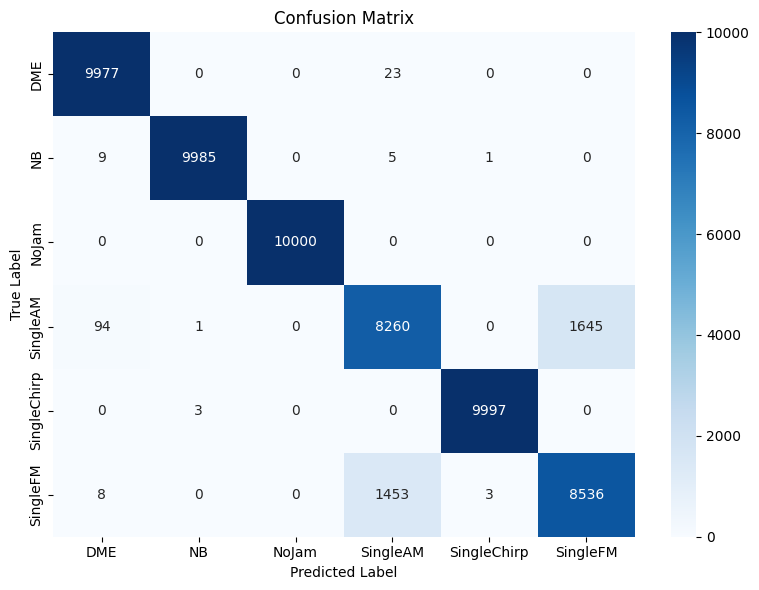

In [77]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# 计算混淆矩阵
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

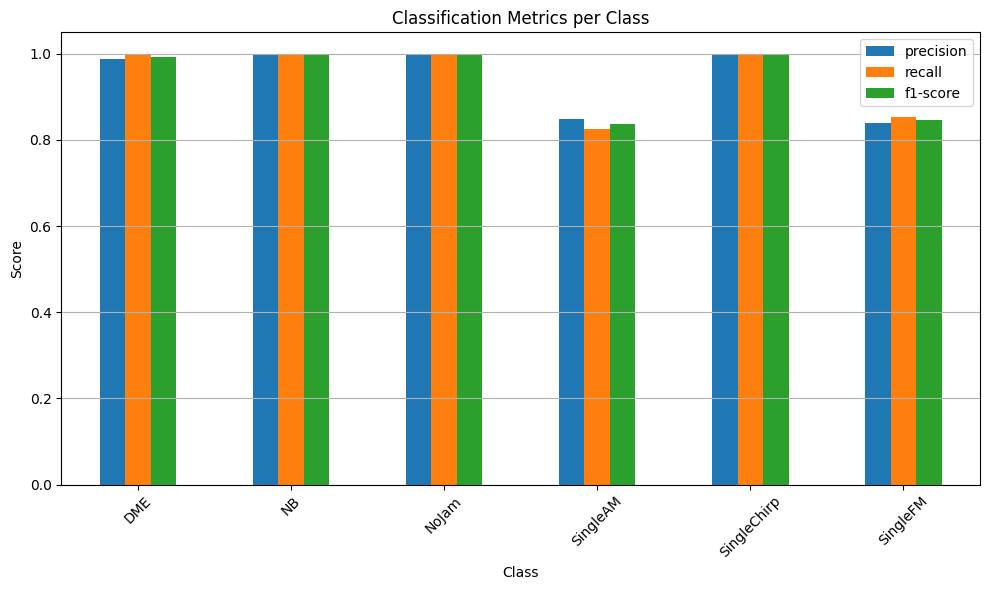

In [78]:
from sklearn.metrics import classification_report
import pandas as pd

# 转换 classification_report 为 DataFrame
report_dict = classification_report(all_labels, all_preds, target_names=classes, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()

# 去除最后两行（accuracy 和 avg）
class_metrics = report_df.iloc[:-3][["precision", "recall", "f1-score"]]

# 绘图
class_metrics.plot(kind="bar", figsize=(10, 6))
plt.title("Classification Metrics per Class")
plt.xlabel("Class")
plt.ylabel("Score")
plt.ylim(0, 1.05)
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()
